# Takeda 
## Data Challenge
*************************

### Introduction

The importance of Diabetes in our daily lives has been known for nearly 200 years. In this challenge, the goal is
to analyse a dataset of 769 patients, primarily taken from people in India; the gender distribution is 318 male and 350 female patients. Additionally, it can be observed that occurrence of diabetes is independent of gender (with 34% of all male and 35% of all female patients having diabetes).

In the next step, we want to analyze the different measured parameters, and understand their ability to distinguish
Diabetes patients from healthy ones.

### About the dataset

The dataset is found on [kaggle](https://www.kaggle.com/uciml/pima-indians-diabetes-database/home) under the name Pima Indians Diabetes Database. The following description was directly taken from the website:

"This dataset is originally from the National Institute of Diabetes and Digestive and Kidney Diseases. The objective of the dataset is to diagnostically predict whether or not a patient has diabetes, based on certain diagnostic measurements included in the dataset. Several constraints were placed on the selection of these instances from a larger database. In particular, all patients here are females at least 21 years old of Pima Indian heritage.

The datasets consists of several medical predictor variables and one target variable, Outcome. Predictor variables include the number of pregnancies the patient has had, their BMI, insulin level, age, and so on."

### Analysis of parameters

For each of the 769 patients, we are given a set of 12 different parameters. In the first analysis, we want to cluster the individuals with Diabetes Type I and Diabetes Type II. Therefore, a quick summary of the parameters important for this determination is given in the following Table, adapted from [[1]](https://www.diabetes.co.uk/difference-between-type1-and-type2-diabetes.html). 

<!-- How can I center-align the entries of this table? -->

| Diabetes Type I                           | Diabetes Type II                                    |
|-------------------------------------------|-----------------------------------------------------|
| Diagnosis at an early age                 | Diagnosed in people over 30 years old.              |
| BMI is not a factor.                      | Association with being overweight.                  |
| Higher ketone levels (not measured here). | High blood pressure often found.                    | 
| Causes are unknown, partially genetics.   | Complex causes, ranging from lifestyle to genetics. |

Given this Table, it is obvious that the most imporant parameters for distinguishing type I from type II diabetes are the age, the BMI and blood pressure. Those will be used for the first part in the data analysis.


## Clustering and visualisation of individuals with Diabetes Type I and Type II

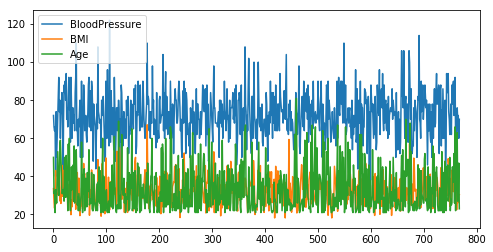

In [1]:
import numpy as np
import pandas as pd
from utils import *
%matplotlib inline

""" 
Cleaning the data
"""

# Read in the dataframe with all it's data
df = pd.read_csv("diabetes.csv")

# Make sure that all relevant numeric data are type 'float'
t1_t2 = df[['BloodPressure', 'BMI', 'Age']].astype('float')

# Clean the data so that unrealistic values are removed.
t1_t2_clean = t1_t2[ (df.BloodPressure > 0)
                    & (df.BMI > 0) ]

# Show a quick overview of the data
plot_overview(t1_t2_clean)

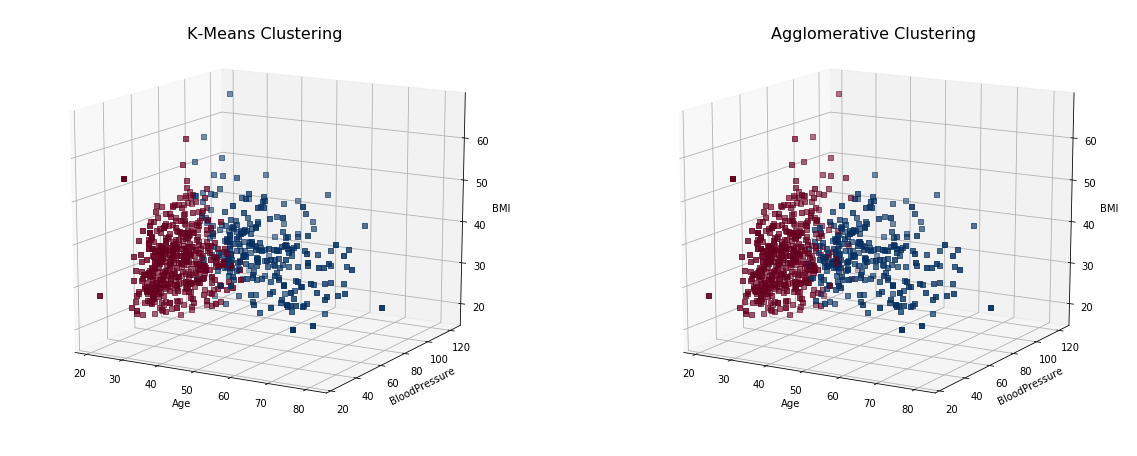

In [2]:
from sklearn.cluster import KMeans, AgglomerativeClustering

"""
Using different clustering algorithms to see which one gives the best result
"""

# Use standard K-Means with two clusters (type I/II) as a first step
kmeans = KMeans(n_clusters=2).fit(t1_t2_clean)

# For comparison, also use Agglomerative Clustering with two clusters (type I/II)
agglo = AgglomerativeClustering(n_clusters=2).fit(t1_t2_clean)

# Visualize the results of both clustering algorithms in 3D
plot_3D(t1_t2_clean, kmeans.labels_, agglo.labels_, "K-Means Clustering", "Agglomerative Clustering")

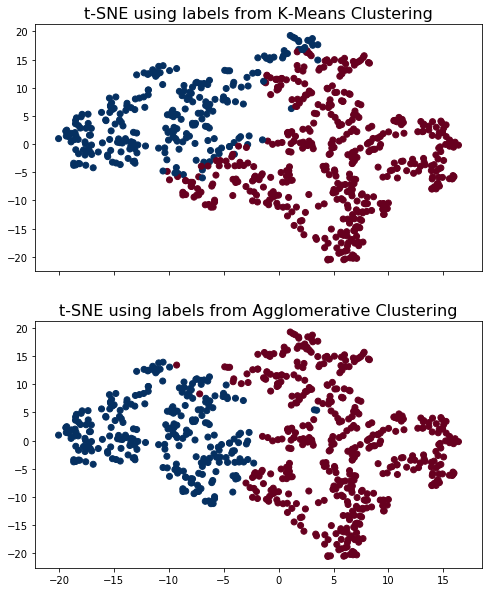

In [3]:
from sklearn.manifold import TSNE

"""
Use dimensionality reduction to visualize the separation of the two clusters
"""

# Perform tSNE on the values with two clusters (type I/II) as a first step
tsne = TSNE(n_components=2, n_iter=300).fit_transform(t1_t2_clean)

plot_TSNE(tsne, kmeans.labels_, agglo.labels_, "K-Means", "Agglomerative")

╒══════════╤═════════════════╤══════════╤═══════════╕
│          │ BloodPressure   │ BMI      │ Age       │
╞══════════╪═════════════════╪══════════╪═══════════╡
│ Class I  │ 66 +/- 9        │ 31 +/- 6 │ 26 +/- 5  │
├──────────┼─────────────────┼──────────┼───────────┤
│ Class II │ 82 +/- 10       │ 34 +/- 7 │ 44 +/- 11 │
╘══════════╧═════════════════╧══════════╧═══════════╛


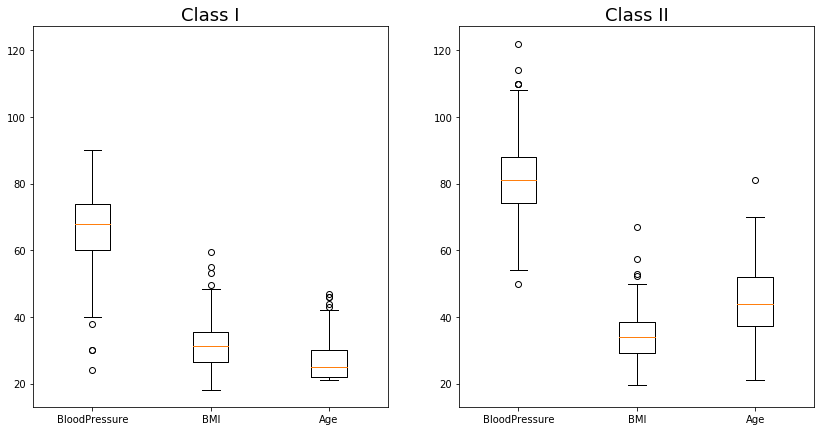

In [4]:
# Find the average BMI, BloodPressure and Age with their STD of each class; output a table
print_tab(t1_t2_clean, kmeans.labels_)

# Visualize the result in a boxplot!
plot_boxplot(t1_t2_clean, kmeans.labels_)

### Summary

Using only the features BloodPressure, BMI and Age, it is possible to visualize the data. Using tSNE on the data leads to a separation of the points in two dimensions; however, it is still not possible to clearly separate the data into certain clusters.

In order to reveal the difference between Diabetes Type I and Type II, the data is clustered with both KMeans and Agglomerative Clustering, using two as the number of clusters. KMeans is further used, as it manages to separate the data better than Agglomerative Clustering.

The boxplots as well as the tables show the differences between the two clusters well. As expected, one of the classes has higher values for the blood pressure, the BMI and the age. This is in accordance to the table above, which shows the major causes for Diabetes Type II. 

Before jumping to quick conclusions, it must be mentioned that the separation of the data into two clusters might have other causes. In order to analyze those potential causes, one could do further analysis with different number of clusters; like that, it is possible to find out the optimal number of clusters. Alternatively, having a dataset with labels for Diabetes Type I and Type II would increase the possibilities for analysis drastically. To concentrate on other aspects of this dataset, I will not cover those approaches here.

--------

## Supervised learning - predictive analysis of Diabetes dataset

So far, the focus here was on clustering the data in two separate groups, based on the assumption that patients with Diabetes type I and type II would be distinguishable. Further on, the class label ('Outcome') will be included in the analysis. This will allow for a supervised learning approach to predict whether a patient is diabetes positive or negative. 
The goal is to measure the importance of each feature from the dataset in a first step; the most relevant ones could then be used for the predictive analysis, and the rest would be ignored to prevent the inclusion of unnecessary noise. 
In the next steps, various algorithms are used to predict whether the patients are diabetes positive or negative. Together with the class label, it will be possible to classify how well the different algorithms performed.

### Feature Selection

The dataset contains many different features; some of them are obviously useful (e.g. age), and others might be less so (e.g. pregnancies). However, as the features in the previous chapter were selected based on a scientific paper, this time, the goal is to do feature selection based on the data itself.
For this, Backward Elimination, a very basic approach, will be used first. The results will then be compared with the [ExtraTreesClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html), which outputs a list of importance scores for each feature, based on which the most important features can be selected.

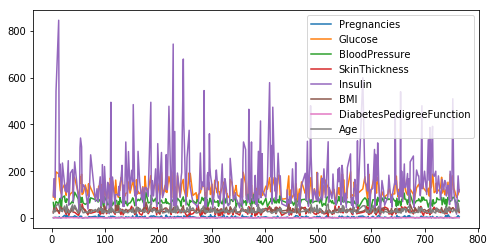

In [5]:
# Read in the dataframe with all it's data
df = pd.read_csv("diabetes.csv")

# Clean the data so that unrealistic values are removed.
clean = clean_data(df)

# Show a quick overview of the data
plot_overview(clean.iloc[:,0:8])

In [6]:
X = clean.iloc[:,0:8]
Y = clean.iloc[:,8]
num_feat = 4

# Use backward elimination
# Input: the data, the labels for each column and the number of features that should be selected
# Output: prints the features to pick, and outputs a vector with the Pearson Correlation Coefficient of each important feature
feat_b_e = backward_elimination(X, Y, num_feat)

Backward elimination
	Eliminated 4 features.
	The remaining features are: Glucose, Insulin, BMI, Age.


In [7]:
# Now use ExtraTreesClassifier as a comparison
# Input: the data, the labels for each column and the number of features that should be selected
# Output: prints the features to pick, and outputs a vector with score of each important feature
feat_e_t = extra_trees(X, Y, num_feat)

Backward elimination
	Eliminated 4 features.
	The remaining features are: Glucose, Insulin, BMI, Age.


Looking at the results, it is clear that the Pearson Correlation Coefficient gives a stable result. Using the ExtraTreesClassifier, without setting a certain random_state, the results vary quite a bit. Additionally, considering the feature score vector from ExtraTrees, there is no clear cut between a 'good' and a 'bad' feature. However, 

In the next step, we will use this data in various ways. Using a basic classifier (such as Linear Regression), we should be able to find out how the predictive capacity is based on different parameters for num_feat. Furthermore, there exist many classification algorithms that are able to automatically select important features and discard noisy ones. More on that in the following chapter.

### Classification

*IDEA: CREATE A BIOLOGICAL THEORY. FOR EXAMPLE, A THEORY COULD BE THAT AGE AND BMI IS VERY IMPORTANT TO PREDICT DIABETES.*

**Choose Training and Test Sets**

In [8]:
from sklearn.model_selection import train_test_split
# In a first step, the data is simply split in a 70/30 fashion
# We are not considering any cross-validation or bootstrapping methods here

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3)

**Logistic Regression**

In [14]:
from sklearn.linear_model import LogisticRegression

# Build the linear regression model
logreg = LogisticRegression()

logreg.fit(X_train, Y_train)

predictions = logreg.predict(X_test)

# Calculate TP, FP, TN, FN, Accuracy and FPR
computeAccuracy(Y_test, predictions);

TP: 		22
FP: 		8
TN: 		67
FN: 		21
Accuracy: 	0.754
FPR: 		0.107


0.7542372881355932

**Support Vector Machines**

USE CROSS VALIDATION AS WELL!!